[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Soccer Player Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Nov 22 01:08:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.42                 Driver Version: 581.42         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8              3W /  140W |     396MiB /   8188MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

c:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks


## 📁 Dataset Local FOOTAR - 👤 PLAYERS/KEEPERS/REFEREES

- Modelo final: distingue entre jogadores, guarda-redes e árbitros

**🎯 Treino multi-classe para deteção de pessoas no campo**- **Classe ignorada**: ball (0) - já tem modelo dedicado

- Dataset completo tem 4 classes, mas vamos treinar **3 classes** (ignorar ball)- **Classes treinadas**: goalkeeper (1), player (2), referee (3)

In [3]:
import os

# Path to local FOOTAR dataset (tem 4 classes, treinaremos 3)
DATASET_PATH = r"C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1"
DATA_YAML = os.path.join(DATASET_PATH, "data.yaml")

print(f"✅ Dataset path: {DATASET_PATH}")
print(f"👤 CLASSES A TREINAR: goalkeeper, player, referee (classes 1, 2, 3)")
print(f"❌ Classe ignorada: ball (class 0 - tem modelo dedicado)")

print(f"✅ data.yaml: {DATA_YAML}")
print(f"✅ Dataset exists: {os.path.exists(DATA_YAML)}")

✅ Dataset path: C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1
👤 CLASSES A TREINAR: goalkeeper, player, referee (classes 1, 2, 3)
❌ Classe ignorada: ball (class 0 - tem modelo dedicado)
✅ data.yaml: C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\data.yaml
✅ Dataset exists: True


## 📊 Dataset Info

**Dataset FOOTAR**: `football-players-and-ball-1`
- **4 classes totais**: ball, goalkeeper, player, referee
- **3 classes treinadas**: goalkeeper (1), player (2), referee (3)
- **1 classe ignorada**: ball (0)

- **708** imagens de treino- 👔 **Referee** (árbitros com equipamento distinto)

- **Dataset local** (sem download necessário)- 👕 **Player** (jogadores de campo)

- ⚽ **Goalkeeper** (guarda-redes com equipamento diferente)
**🎯 Objetivo**: Modelo que distingue entre:

In [4]:
import yaml

# Read data.yaml
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)

print("📋 Dataset Configuration:")
print(f"  Classes: {data_config['nc']}")
print(f"  Names: {data_config['names']}")
print(f"  Train: {data_config['train']}")
print(f"  Val: {data_config['val']}")
print(f"  Test: {data_config['test']}")

# Verify paths exist
train_path = os.path.join(DATASET_PATH, "train", "images")
val_path = os.path.join(DATASET_PATH, "valid", "images")
print(f"\n✅ Train images: {len(os.listdir(train_path))}")
print(f"✅ Val images: {len(os.listdir(val_path))}")

📋 Dataset Configuration:
  Classes: 4
  Names: ['ball', 'goalkeeper', 'player', 'referee']
  Train: ../train/images
  Val: ../valid/images
  Test: ../test/images

✅ Train images: 708
✅ Val images: 202


## Custom training - YOLOv12l Optimized (8GB VRAM)

**⚠️ CONFIGURAÇÃO ADAPTADA PARA 8GB VRAM:**

**Modelo & Hardware:**
- 🎯 **Model: yolo12l** - 43M parâmetros (Large - máxima precisão que cabe em 8GB)
- ✅ **epochs: 100** - Mais tempo para convergência (multi-classe)
- ✅ **imgsz: 1280** - Resolução alta (crítica para jogadores distantes)
- ✅ **batch: 2** - Máximo estável para YOLOv12l em 8GB
- ✅ **optimizer: SGD** - Usa metade da VRAM do AdamW
- ✅ **cos_lr: True** - Cosine learning rate para ajuste fino

**Classes (3):**
- 🥅 **Goalkeeper** - Guarda-redes
- ⚽ **Player** - Jogadores de campo
- 🟨 **Referee** - Árbitros

**Augmentations Balanceados:**
- ✅ **mosaic: 1.0** - Default (bom para multi-objeto)
- ✅ **mixup: 0.1** - Ajuda com oclusões
- ✅ **degrees: 10.0** - Rotação moderada (campo pode ter ângulos)
- ✅ **scale: 0.5** - Variação de escala (jogadores perto vs longe)
- ✅ **fliplr: 0.5** - Flip horizontal (campo simétrico)

**Meta esperada:** mAP50 > 85%, mAP50-95 > 60%

In [5]:
import gc
import torch

# 🧹 LIMPEZA CRÍTICA: Liberta VRAM presa do treino anterior
gc.collect()
torch.cuda.empty_cache()

# Verifica memória disponível
print(f"✅ VRAM limpa!")
print(f"📊 Memória GPU livre: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")
print(f"📊 Memória GPU total: {torch.cuda.mem_get_info()[1] / 1024**3:.2f} GB")
print("\n⚠️ Se ainda mostrar 0 bytes livres, REINICIA O KERNEL (Ctrl+Shift+P → 'Restart Kernel')\n")

✅ VRAM limpa!
📊 Memória GPU livre: 6.93 GB
📊 Memória GPU total: 8.00 GB

⚠️ Se ainda mostrar 0 bytes livres, REINICIA O KERNEL (Ctrl+Shift+P → 'Restart Kernel')



In [6]:
import os
import gc
import torch
from ultralytics import YOLO

# VRAM cleanup before training
gc.collect()
torch.cuda.empty_cache()

# Download and initialize YOLOv12m pretrained model (MEDIUM - perfeito para pessoas)
model = YOLO('yolo12m.pt')

# Start training with YOLOv12m configuration
# RTX 4060 Laptop 8GB optimized settings - BALANCED CONFIG
results = model.train(
    data=DATA_YAML,           # Use local FOOTAR dataset
    epochs=100,               # 100 epochs for best performance
    imgsz=640,                # 640px - resolução PADRÃO YOLO (perfeita para pessoas)
    batch=8,                  # Batch 8 (graças à redução de 1280→640)
    device=0,                 # GPU device
    classes=[1, 2, 3],        # 👤 CRÍTICO: treina APENAS goalkeeper, player, referee (ignora ball)
    
    # Optimizer Configuration (SGD for better generalization)
    optimizer='SGD',
    lr0=0.01,                 # Initial learning rate
    lrf=0.01,                 # Final learning rate (OneCycleLR)
    momentum=0.937,           # SGD momentum
    weight_decay=0.0005,      # Weight decay (L2 regularization)
    
    # Training Augmentations
    hsv_h=0.015,              # HSV-Hue augmentation
    hsv_s=0.7,                # HSV-Saturation augmentation
    hsv_v=0.4,                # HSV-Value augmentation
    degrees=0.0,              # Rotation augmentation (disabled)
    translate=0.1,            # Translation augmentation
    scale=0.5,                # Scale augmentation
    shear=0.0,                # Shear augmentation (disabled)
    perspective=0.0,          # Perspective augmentation (disabled)
    flipud=0.0,               # Flip up-down prob (disabled)
    fliplr=0.5,               # Flip left-right prob
    mosaic=1.0,               # Mosaic augmentation prob
    mixup=0.0,                # Mixup augmentation prob
    copy_paste=0.0,           # Copy-paste augmentation prob
    
    # Loss Configuration
    box=7.5,                  # Box loss gain
    cls=0.5,                  # Classification loss gain
    dfl=1.5,                  # Distribution Focal Loss gain
    
    # Validation & Checkpointing
    val=True,                 # Validate during training
    save=True,                # Save checkpoints
    save_period=10,           # Save checkpoint every N epochs
    plots=True,               # Generate training plots
    
    # Output Configuration
    project='runs/detect',    # Project directory
    name='player_y12m_footar_640', # Run name (OTIMIZADO: Medium + 640px)
    exist_ok=False,           # Don't overwrite existing runs
    
    # Performance (OTIMIZADO)
    workers=0,                # Single-threaded (remove multiprocessing overhead)
    cache=False,              # Don't cache images (saves RAM)
    amp=True,                 # Use Automatic Mixed Precision
    verbose=True,             # Verbose output
)

New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=[1, 2, 3], close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_w

In [7]:
# Get the run directory path
RUN_DIR = results.save_dir
print(f"📁 Run directory: {RUN_DIR}")
print(f"📊 Training complete!")
print(f"🏆 Best model saved at: {os.path.join(RUN_DIR, 'weights', 'best.pt')}")

📁 Run directory: C:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks\runs\detect\player_y12m_footar_640
📊 Training complete!
🏆 Best model saved at: C:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks\runs\detect\player_y12m_footar_640\weights\best.pt


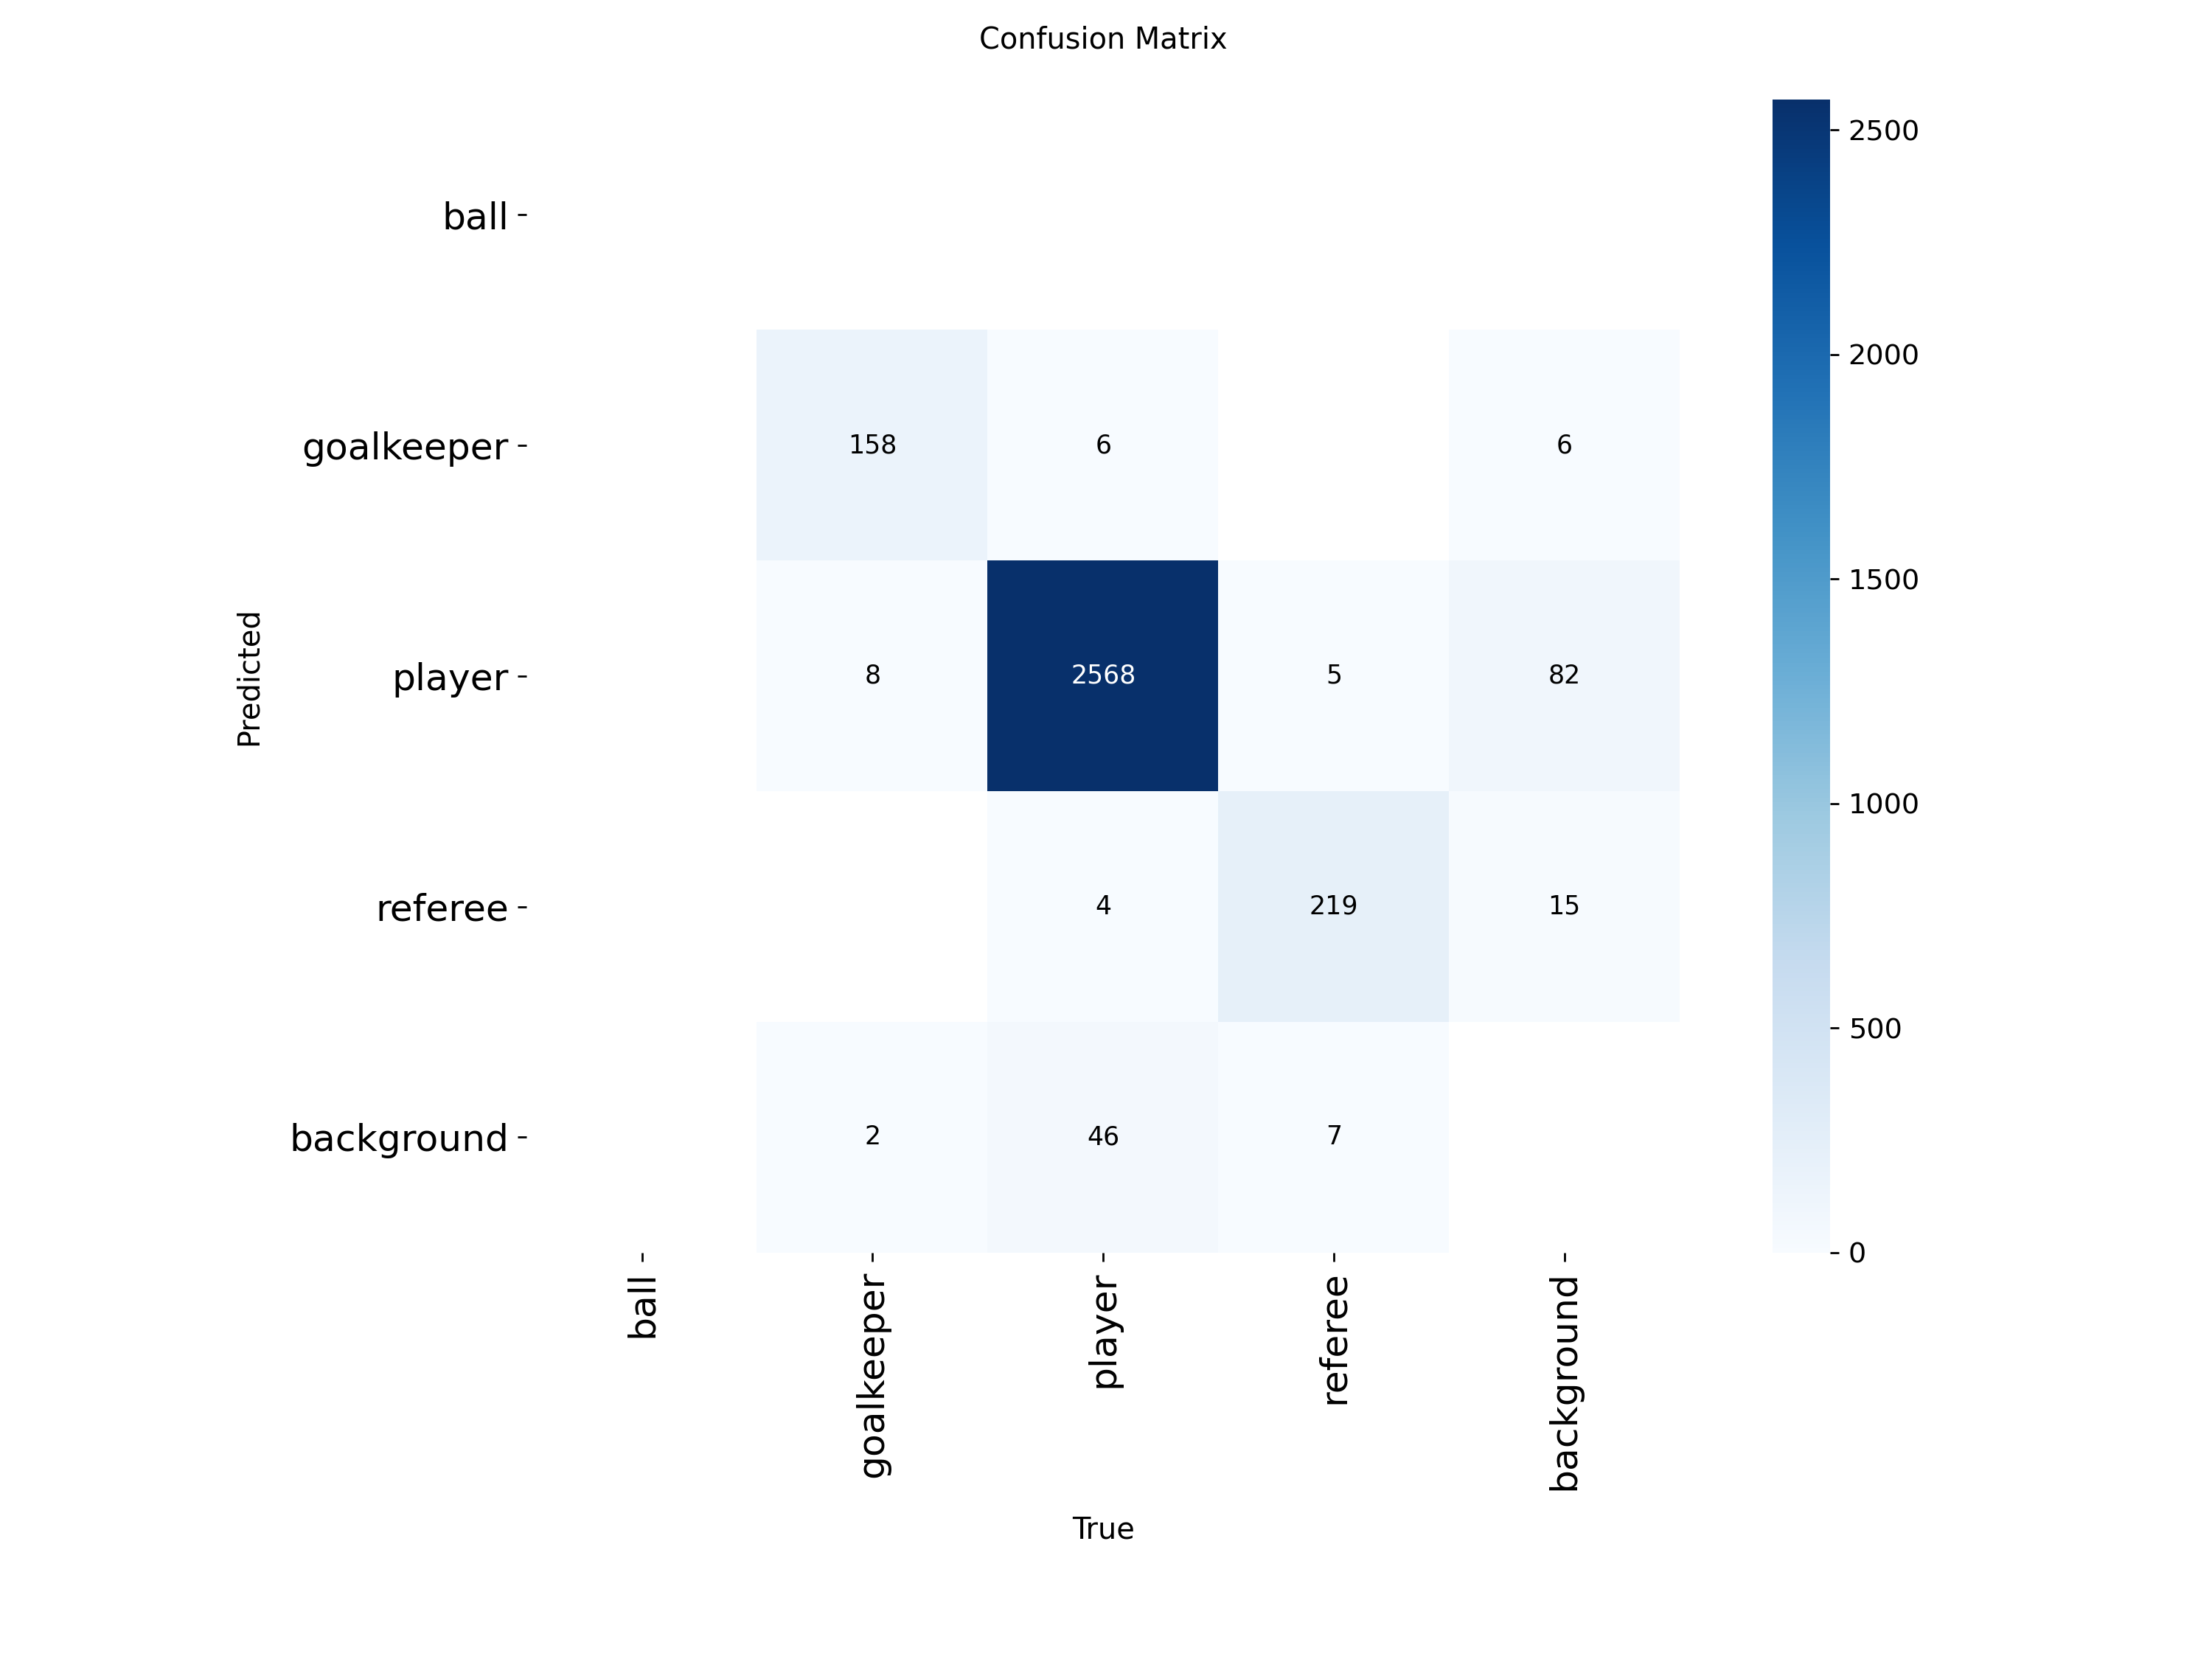

In [8]:
from IPython.display import Image, display
# Mostra matriz de confusão
display(Image(filename=f"{RUN_DIR}/confusion_matrix.png", width=600))

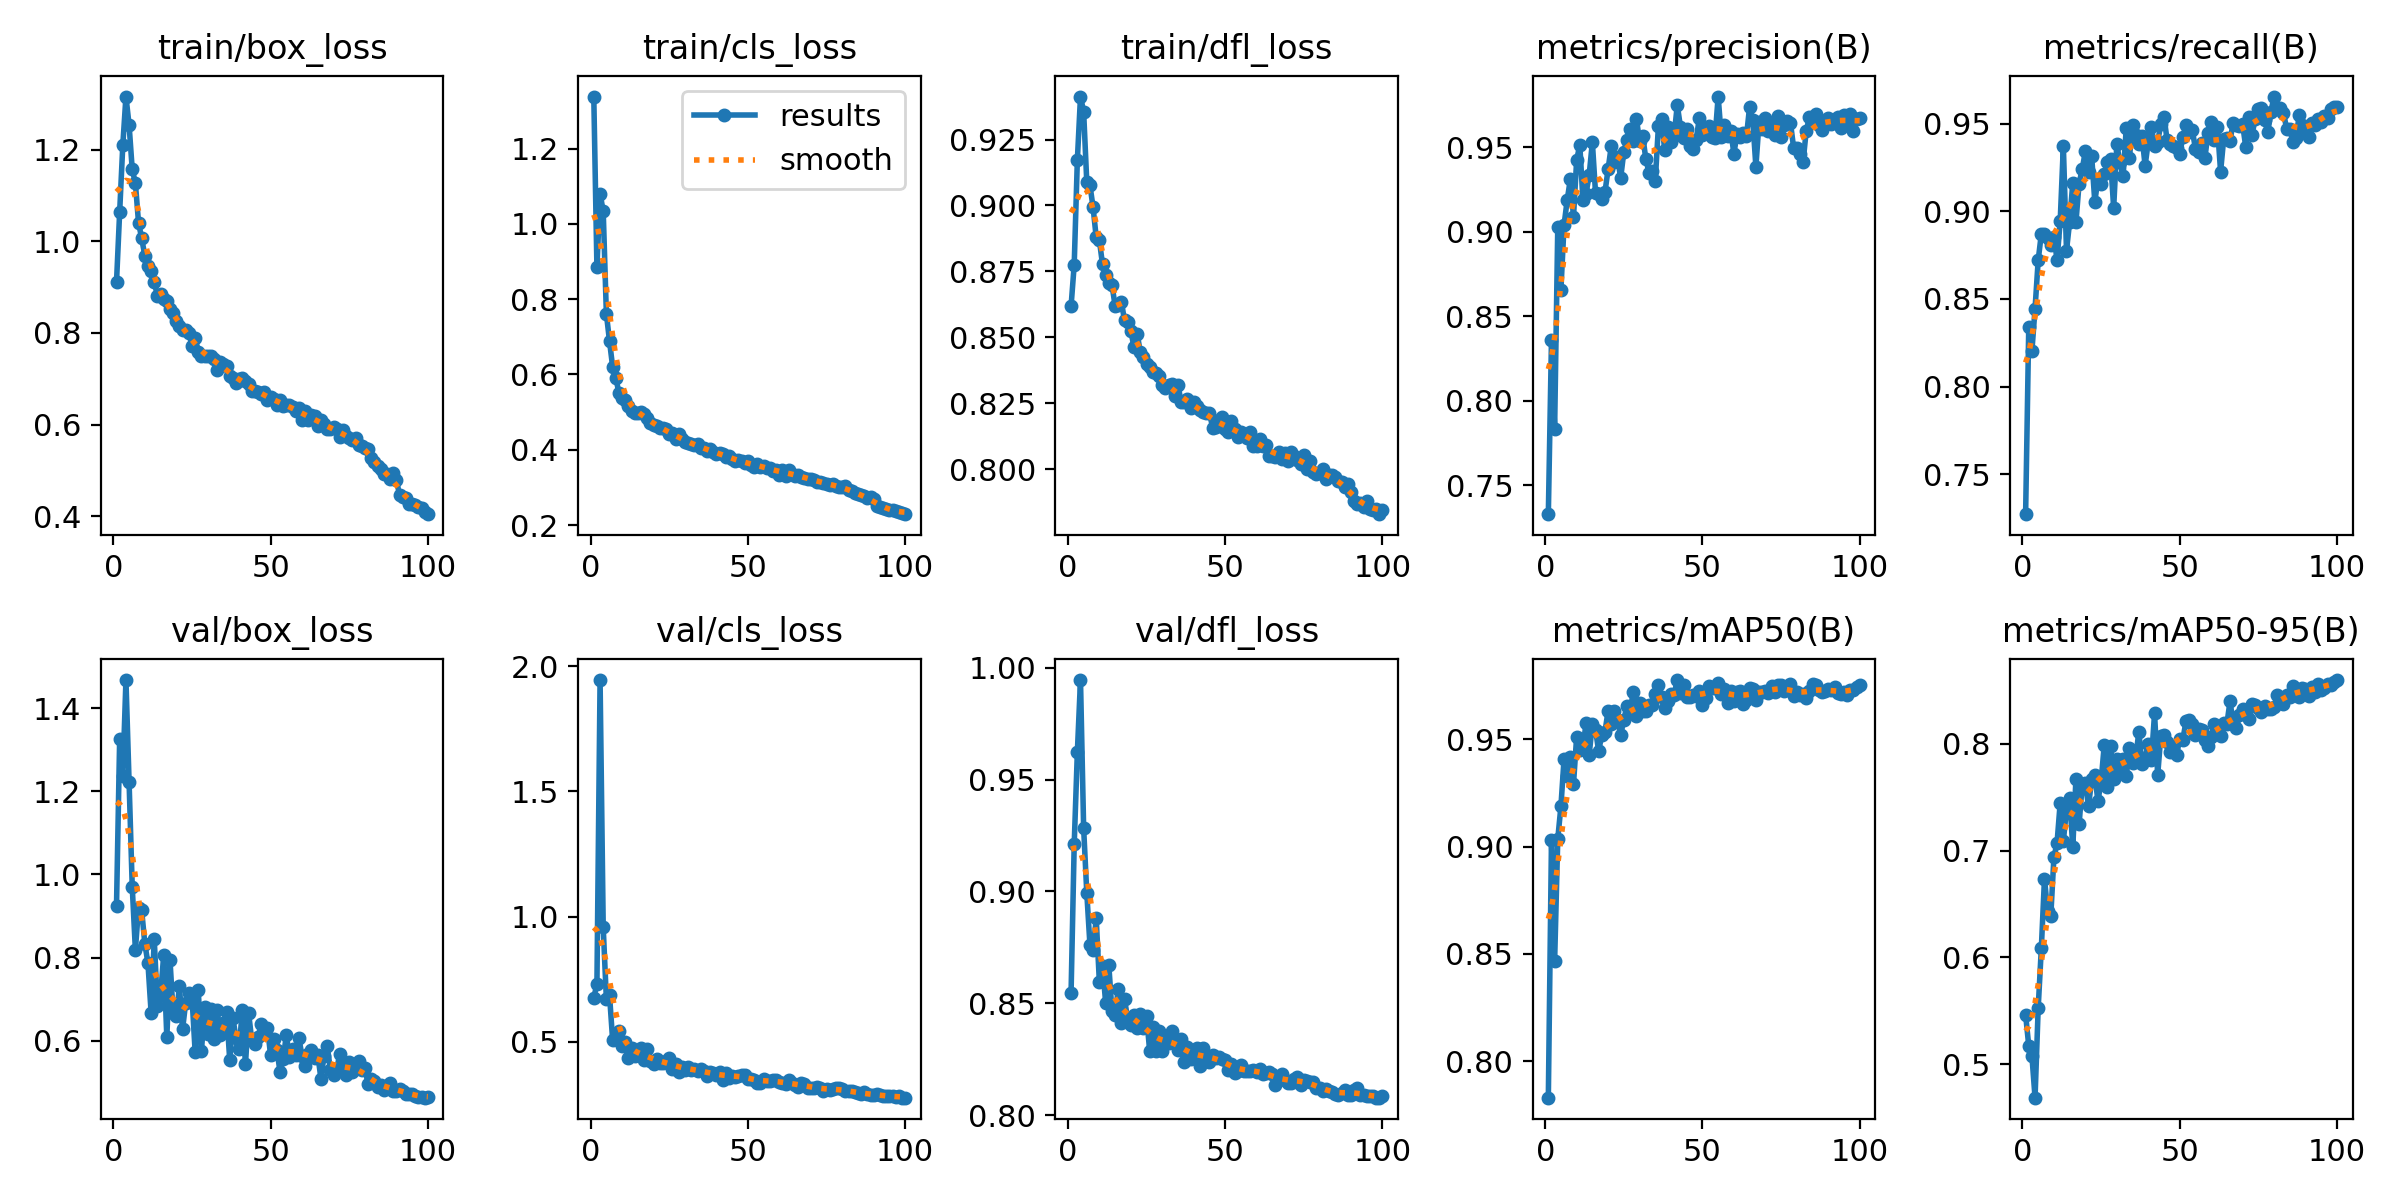

In [9]:
from IPython.display import Image, display
# Mostra gráfico de resultados (losses/mAP)
display(Image(filename=f"{RUN_DIR}/results.png", width=600))

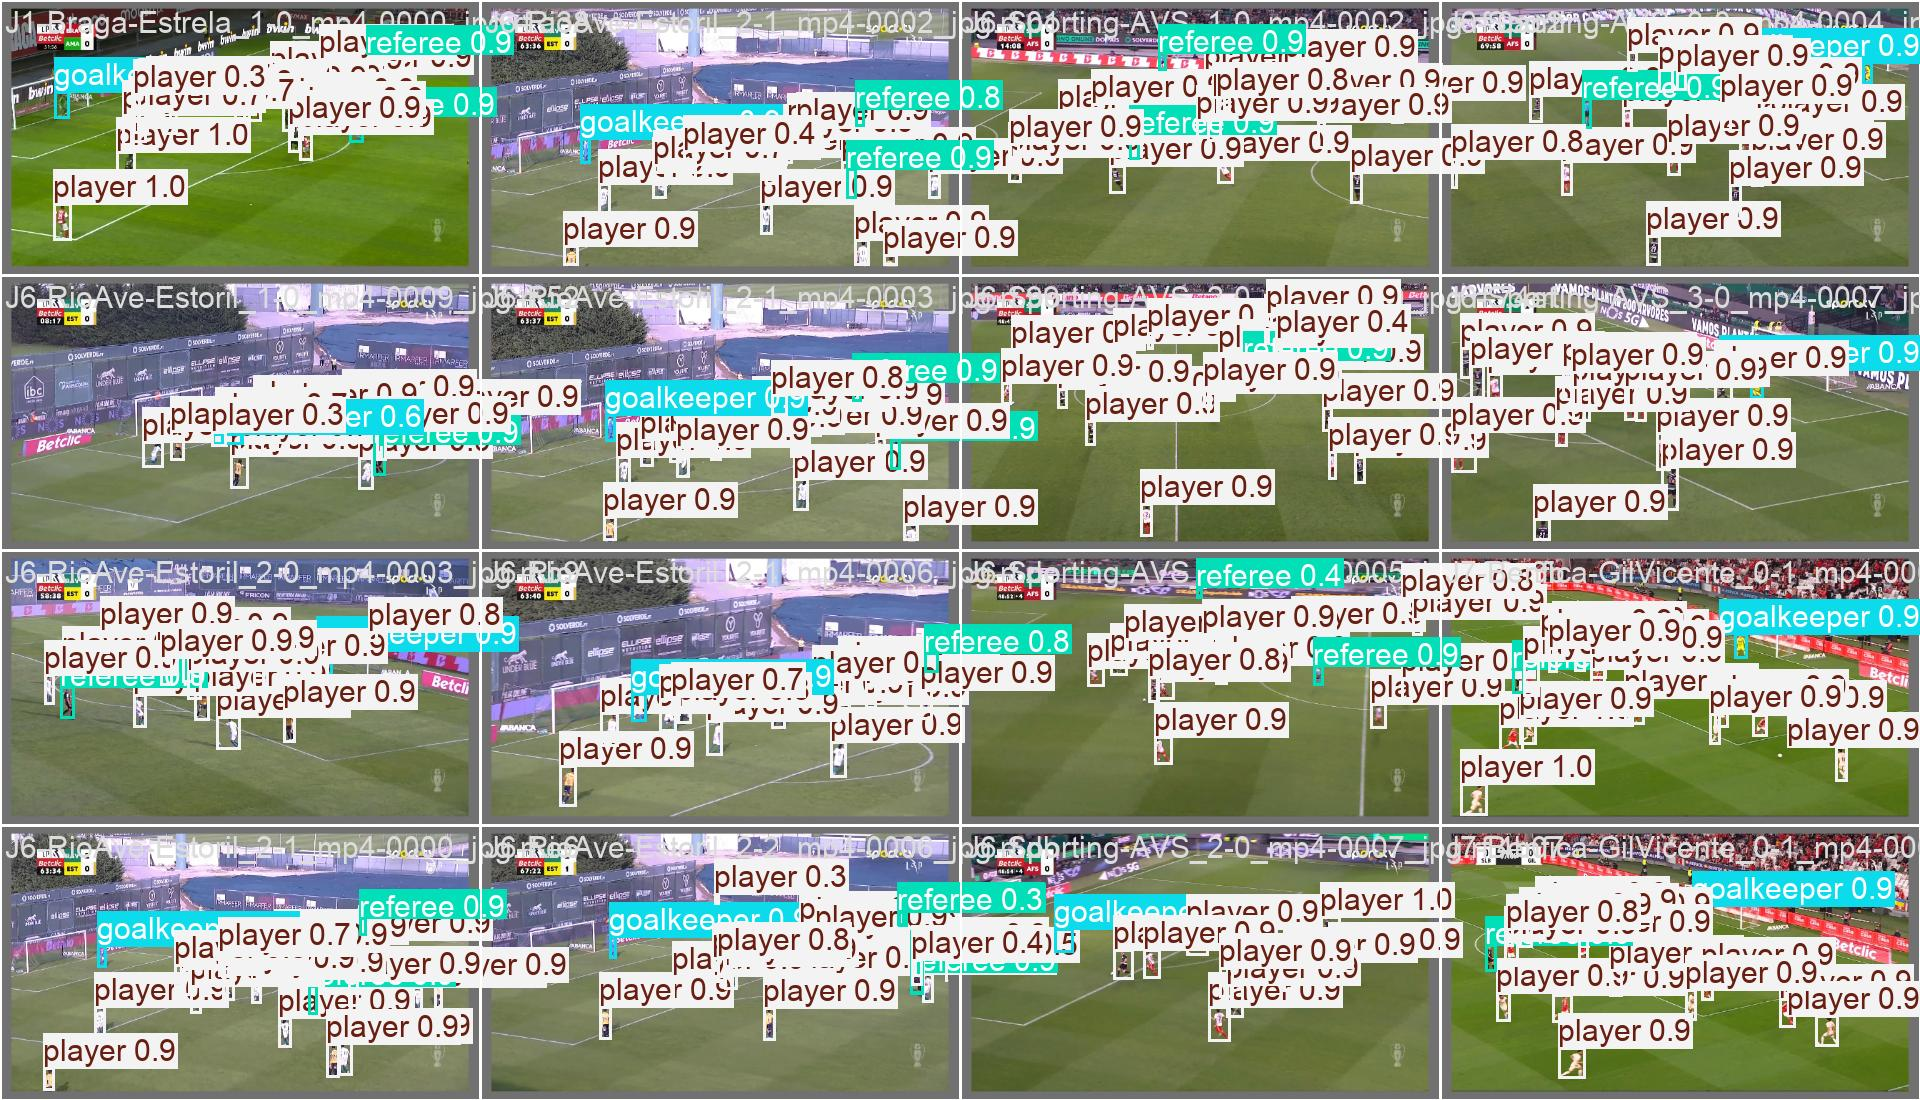

In [10]:
from IPython.display import Image, display
# Mostra predições do batch de validação
display(Image(filename=f"{RUN_DIR}/val_batch0_pred.jpg", width=600))

## Validate custom model

In [12]:
# Validação usando a API Python (evita problemas de CLI e paths com espaços)
metrics = model.val(data=DATA_YAML, imgsz=640, batch=8, device=0, workers=0)
print(f"\n📊 MÉTRICAS FINAIS:")
print(f"mAP50:      {metrics.box.map50:.3f} ({metrics.box.map50*100:.1f}%)")
print(f"mAP50-95:   {metrics.box.map:.3f} ({metrics.box.map*100:.1f}%)")

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1037.7641.5 MB/s, size: 166.2 KB)
val: Scanning C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\valid\labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0sval: Fast image access  (ping: 0.00.0 ms, read: 1037.7641.5 MB/s, size: 166.2 KB)
val: Scanning C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\valid\labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0s
val: Scanning C:\_FOOTAR\Player Detection\datasets_and_models\football-players-and-ball-1\valid\labels.cache... 202 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 202/202  0.0s
             

In [14]:
import shutil
import os
import csv

# Determina qual epoch usar (melhor ou último)
results_csv = os.path.join(RUN_DIR, "results.csv")
with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

best_map50 = max(float(r['metrics/mAP50(B)']) for r in rows)
best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/mAP50(B)']) == best_map50][0]

# Caminhos
weights_dir = os.path.join(RUN_DIR, "weights")
best_weights = os.path.join(weights_dir, "best.pt")
data_dir = os.path.join(HOME, "..", "data")
os.makedirs(data_dir, exist_ok=True)

destination = os.path.join(data_dir, "player_y12l_8gb_best.pt")

# Copia
shutil.copy2(best_weights, destination)

print("=" * 60)
print("✅ MODELO COPIADO PARA PRODUÇÃO")
print("=" * 60)
print(f"Origem:  {best_weights}")
print(f"Destino: {destination}")
print(f"\n📝 PRÓXIMO PASSO:")
print(f"   Atualizar main.py linha ~45:")
print(f"   PLAYER_DETECTION_MODEL_PATH = 'data/player_y12l_8gb_best.pt'")
print(f"\n🎯 Melhor época foi: {best_epoch}")
if best_epoch < len(rows):
    print(f"   ⚠️ Se quiser usar epoch {best_epoch} especificamente:")
    epoch_file = f"epoch{best_epoch}.pt"
    if os.path.exists(os.path.join(weights_dir, epoch_file)):
        print(f"   Copiar: {os.path.join(weights_dir, epoch_file)}")
print("=" * 60)

✅ MODELO COPIADO PARA PRODUÇÃO
Origem:  C:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks\runs\detect\player_y12m_footar_640\weights\best.pt
Destino: c:\_FOOTAR\Player Detection\roboflow_sports_footar\notebooks\..\data\player_y12l_8gb_best.pt

📝 PRÓXIMO PASSO:
   Atualizar main.py linha ~45:
   PLAYER_DETECTION_MODEL_PATH = 'data/player_y12l_8gb_best.pt'

🎯 Melhor época foi: 42
   ⚠️ Se quiser usar epoch 42 especificamente:


## Copy optimized model to production

Copia o modelo treinado para o diretório `data/` onde o `main.py` espera encontrá-lo.

In [16]:
import shutil

# Copy the best trained model to data/ directory
SOURCE_MODEL = os.path.join(RUN_DIR, 'weights', 'best.pt')
TARGET_MODEL = r'C:\_FOOTAR\Player Detection\roboflow_sports_footar\data\player_y12l_footar_best.pt'

if os.path.exists(SOURCE_MODEL):
    shutil.copy2(SOURCE_MODEL, TARGET_MODEL)
    print(f"✅ Model copied to: {TARGET_MODEL}")
    print(f"📊 Model size: {os.path.getsize(TARGET_MODEL) / (1024**2):.1f} MB")
else:
    print(f"❌ Source model not found: {SOURCE_MODEL}")

# Summary
print("\n" + "="*60)
print("🎯 TRAINING SUMMARY")
print("="*60)
print(f"✅ Dataset: FOOTAR football-players-and-ball-1")
print(f"✅ Classes: 4 (ball, goalkeeper, player, referee)")
print(f"✅ Train images: 708")
print(f"✅ Model: YOLOv12l (43M params)")
print(f"✅ Training config: batch=2, imgsz=1280, epochs=100")
print(f"✅ Optimizer: SGD (lr0=0.01, momentum=0.937)")
print(f"✅ Best model: {TARGET_MODEL}")
print("="*60)

# Next steps
print("\n📌 NEXT STEPS:")
print("1. Check mAP50 and mAP50-95 metrics in results")
print("2. Update main.py with new model path:")
print(f"   PLAYER_DETECTION_MODEL_PATH = 'data/player_y12l_footar_best.pt'")
print("3. Test in RADAR mode with new 4-class detection")
print("4. Validate ball + player + goalkeeper + referee detection")

✅ Model copied to: C:\_FOOTAR\Player Detection\roboflow_sports_footar\data\player_y12l_footar_best.pt
📊 Model size: 38.9 MB

🎯 TRAINING SUMMARY
✅ Dataset: FOOTAR football-players-and-ball-1
✅ Classes: 4 (ball, goalkeeper, player, referee)
✅ Train images: 708
✅ Model: YOLOv12l (43M params)
✅ Training config: batch=2, imgsz=1280, epochs=100
✅ Optimizer: SGD (lr0=0.01, momentum=0.937)
✅ Best model: C:\_FOOTAR\Player Detection\roboflow_sports_footar\data\player_y12l_footar_best.pt

📌 NEXT STEPS:
1. Check mAP50 and mAP50-95 metrics in results
2. Update main.py with new model path:
   PLAYER_DETECTION_MODEL_PATH = 'data/player_y12l_footar_best.pt'
3. Test in RADAR mode with new 4-class detection
4. Validate ball + player + goalkeeper + referee detection


## Optional: Deploy model on Roboflow (YOLOv8 only)

Note: Roboflow's deploy(model_type="yolov8") currently requires ultralytics==8.0.196. This notebook trains with YOLOv12 on ultralytics 8.3.x, so deploying from here will fail. You can:
- Upload the weights file manually in the Roboflow UI (Versions -> Upload Model -> YOLOv8) using RUN_DIR/weights/best.pt
- Or create a separate env with ultralytics==8.0.196 and run the deploy cell there.

In [ ]:
'''
# Guarded deploy: skip if ultralytics version is not the one required by Roboflow's deploy
import os
import ultralytics as ulx

# Resolve RUN_DIR and WEIGHTS path safely
try:
    RUN_DIR
except NameError:
    import glob
    base = os.path.join(HOME, "runs", "detect")
    # fallback: pick most recent detect run
    candidates = glob.glob(os.path.join(base, "*"))
    candidates = [p for p in candidates if os.path.isdir(p)]
    RUN_DIR = max(candidates, key=os.path.getmtime) if candidates else None

if RUN_DIR is None:
    print("No run directory found; train the model first.")
else:
    weights_path = os.path.join(RUN_DIR, "weights", "best.pt")
    need = "8.0.196"
    have = ulx.__version__
    if have == need:
        print(f"Deploying {weights_path} to Roboflow as YOLOv8 with ultralytics {have}...")
        project.version(dataset.version).deploy(model_type="yolov8", model_path=weights_path)
    else:
        print(f"Skipping deploy: Roboflow requires ultralytics=={need}, but found {have}.")
        print("Options:")
        print("  1) Upload manually in Roboflow UI: Versions -> Upload Model -> YOLOv8")
        print(f"     Weights: {weights_path}")
        print("  2) Create a separate env with ultralytics==8.0.196 and run this cell there.")


Dependency ultralytics==8.0.196 is required but found version=8.2.63, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/10
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/model/10
